In [1]:
#for data preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
#read our dataset
df = pd.read_csv("silver_price.csv")
#show first 5 examples (in BTC)
df.head(n=5)

,date,price
0,1968-01-02,2.173
1,1968-01-03,2.225
2,1968-01-04,2.171
3,1968-01-05,2.157
4,1968-01-08,2.163


In [3]:
data = df.price
data = data.dropna()

In [4]:
data.shape

(13454,)

In [5]:
data = [float(str(i).replace(",", "")) for i in data]
data = np.array(data)

C:\Users\91976\AppData\Local\Temp\ipykernel_20200\491490045.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, bins=30, kde=False)


<AxesSubplot:>

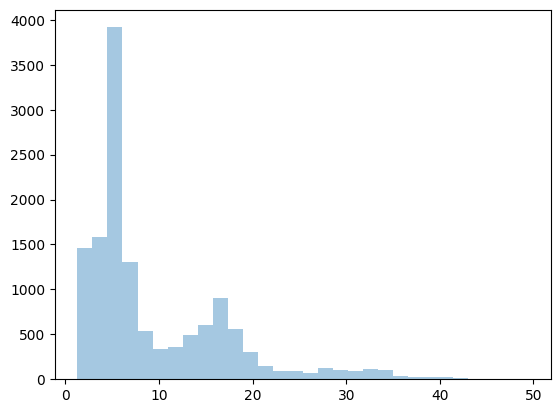

In [6]:
sns.distplot(data, bins=30, kde=False)

C:\Users\91976\AppData\Local\Temp\ipykernel_20200\3640705160.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=stats.norm, bins=30, kde=False,)


<AxesSubplot:>

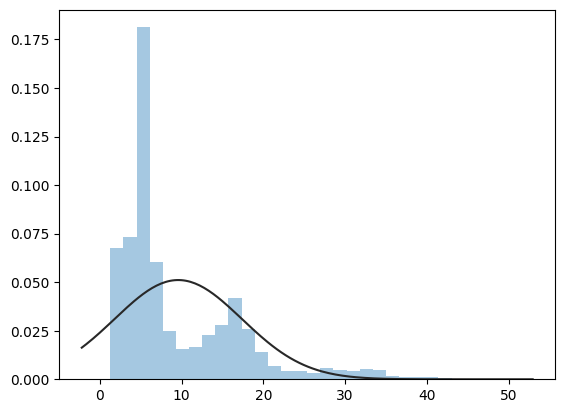

In [7]:
sns.distplot(data, fit=stats.norm, bins=30, kde=False,)

MLE method

In [8]:
def gaussian_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma**2))


In [9]:
def e_step(X, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    gamma = np.zeros((len(X), 2))
    for i, x in enumerate(X):
        likelihood_1 = lambda_1 * gaussian_pdf(x, mu_1, sigma_1)
        likelihood_2 = lambda_2 * gaussian_pdf(x, mu_2, sigma_2)
        total_likelihood = likelihood_1 + likelihood_2
        gamma[i, 0] = likelihood_1 / total_likelihood
        gamma[i, 1] = likelihood_2 / total_likelihood
    return gamma


def m_step(X, gamma):
    N = len(X)
    N1 = np.sum(gamma[:, 0])
    N2 = N - N1

    lambda_1 = N1 / N
    lambda_2 = N2 / N

    mu_1 = np.sum(gamma[:, 0] * X) / N1
    mu_2 = np.sum(gamma[:, 1] * X) / N2

    sigma_1 = np.sum(gamma[:, 0] * np.abs(X - mu_1)) / N1
    sigma_2 = np.sqrt(np.sum(gamma[:, 1] * (X - mu_2)**2) / N2)

    return [lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2]


In [10]:
def log_likelihood(X, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    likelihood = lambda_1 * gaussian_pdf(X, mu_1, sigma_1) + lambda_2 * gaussian_pdf(X, mu_2, sigma_2)
    return np.sum(np.log(likelihood))

In [11]:
def em_algorithm(X, initial_theta, tol=1e-6, max_iter=100):
    theta = initial_theta
    prev_log_likelihood = None

    for i in range(max_iter):
        gamma = e_step(X, theta)
        theta = m_step(X, gamma)
        current_log_likelihood = log_likelihood(X, theta)

        if prev_log_likelihood is not None and np.abs(current_log_likelihood - prev_log_likelihood) < tol:
            break

        prev_log_likelihood = current_log_likelihood

    return theta

In [12]:
initial_theta = [0.5, 0.5, np.mean(data), np.std(data), np.median(data), np.std(data)]

In [13]:
estimated_theta = em_algorithm(data, initial_theta)

In [14]:
print("Estimated Parameters:")
print("lambda_1:", estimated_theta[0])
print("lambda_2:", estimated_theta[1])
print("mu_1:", estimated_theta[2])
print("sigma_1:", estimated_theta[3])
print("mu_2:", estimated_theta[4])
print("sigma_2:", estimated_theta[5])

Estimated Parameters:
lambda_1: 0.3592842979612051
lambda_2: 0.6407157020387949
mu_1: 18.04630626445692
sigma_1: 5.268763079795314
mu_2: 4.831117275894234
sigma_2: 1.7608298607561008


In [15]:
def mixture_pdf(x, theta):
    lambda_1, lambda_2, mu_1, sigma_1, mu_2, sigma_2 = theta
    pdf_value = lambda_1 * gaussian_pdf(x, mu_1, sigma_1) + lambda_2 * gaussian_pdf(x, mu_2, sigma_2)
    return pdf_value


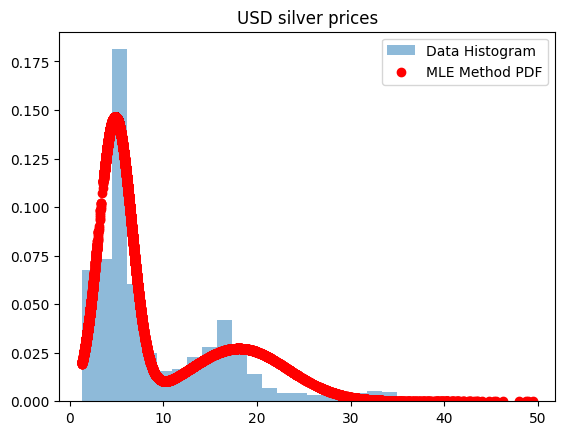

In [16]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
pdf_values = mixture_pdf(data, estimated_theta)
plt.scatter(data, pdf_values, label='MLE Method PDF', color='red')
plt.title('USD silver prices')
plt.legend()

Bayesian Method

In [17]:
from sklearn import mixture

bgmm = mixture.BayesianGaussianMixture(n_components=2 , max_iter = 100)
bgmm.fit(data.reshape(-1 , 1))

BayesianGaussianMixture(n_components=2)

In [18]:
print("Estimated Parameters:")
print("lambda_1:", bgmm.weights_[0])
print("lambda_2:", bgmm.weights_[1])
print("mu_1:", bgmm.means_[0])
print("sigma_1:", bgmm.covariances_[0])
print("mu_2:", bgmm.means_[1])
print("sigma_2:", bgmm.covariances_[1])

Estimated Parameters:
lambda_1: 0.4149832917733455
lambda_2: 0.5850167082266546
mu_1: [16.3875123]
sigma_1: [[63.84021115]]
mu_2: [4.75019296]
sigma_2: [[2.66818914]]


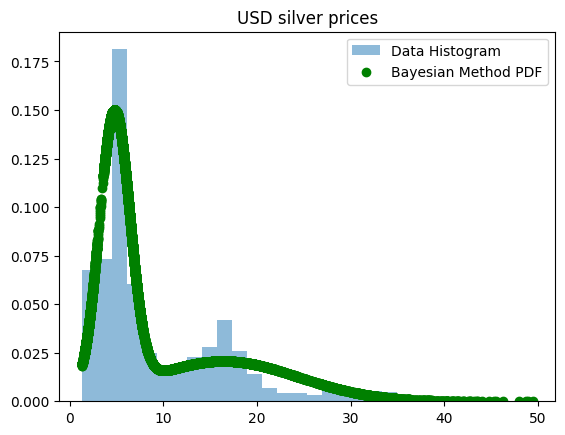

In [19]:
logprob = bgmm.score_samples(data.reshape(-1 , 1))
pdf_values_bay = np.exp(logprob)

plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('USD silver prices')
plt.legend()

Plotting 2 Pdf's togather

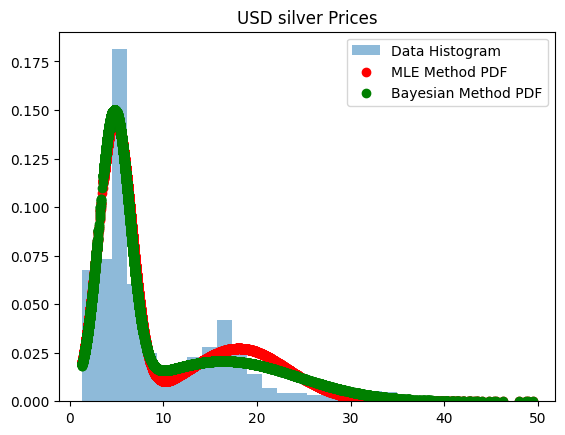

In [20]:
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data Histogram')
plt.scatter(data, pdf_values, label='MLE Method PDF', color='red')
plt.scatter(data, pdf_values_bay, label='Bayesian Method PDF', color='green')
plt.title('USD silver Prices')
plt.legend()

In [21]:
print('KL Divergence between the MLE and Bayesian distribution-->', abs(np.mean(np.log(pdf_values/pdf_values_bay))))

KL Divergence between the MLE and Bayesian distribution--> 0.0617184774177238
